In [8]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

**Problem Stastement:** We have Predict Which is the Popular Song in Spotify Data Set, how to improve training outcomes by including an early stopping callback to prevent overfitting.

In [10]:
spotify = pd.read_csv('Data/spotify.csv')
spotify.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [11]:
import numpy as np
np.max(spotify.track_popularity)

100

In [13]:
X = spotify.copy().dropna() # Droping all Null Values
y = X.pop('track_popularity')
artists =X['track_artist']

In [14]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

In [15]:
# Data Preprocessing From Scikit learn
preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

In [16]:
# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.

In [19]:
def group_split(X,y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X,y,groups= group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

In [20]:
X_train , X_valid ,y_train, y_valid = group_split(X,y,artists)

In [21]:
X_train = preprocessor.fit_transform(X_train)

In [22]:
X_valid = preprocessor.transform(X_valid)

In [23]:
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

In [24]:
input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [25]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])

In [26]:
model.compile(
optimizer='adam',
loss='mae')

In [28]:
history  = model.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0)

Minimum Validation Loss: 0.1964


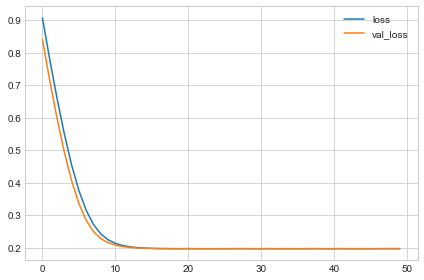

In [29]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Now let's add some capacity to our network. We'll add a couple of hidden layers with 192 units in all. Run the next cell to train the network and see the learning curves.

In [30]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [31]:
model.compile(
    optimizer='adam',
    loss='mae',
)

In [32]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)

Epoch 1/50
49/49 [==============================] - 0s 3ms/step - loss: 0.2697 - val_loss: 0.2099
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 0.2039 - val_loss: 0.2026
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1986 - val_loss: 0.2016
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1959 - val_loss: 0.1997
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1932 - val_loss: 0.1976
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1912 - val_loss: 0.1978
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1901 - val_loss: 0.1982
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1885 - val_loss: 0.1983
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1872 - val_loss: 0.1981
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1865 - val_loss: 0.1974
Epoch 11/50
49/49 [

Minimum Validation Loss: 0.1964


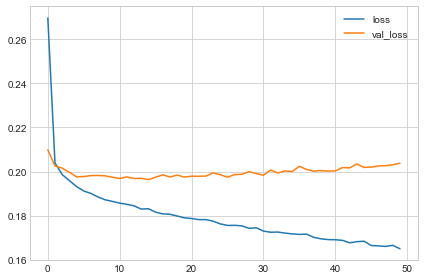

In [33]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

**Define Early Stopping Callback**

In [35]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Epoch 1/50
49/49 [==============================] - 0s 3ms/step - loss: 0.2237 - val_loss: 0.2074
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1996 - val_loss: 0.2024
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1951 - val_loss: 0.2002
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1921 - val_loss: 0.1993
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1906 - val_loss: 0.1996
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1891 - val_loss: 0.1996
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1874 - val_loss: 0.1967
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1867 - val_loss: 0.1971
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1853 - val_loss: 0.1973
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1853 - val_loss: 0.1980
Epoch 11/50
49/49 [

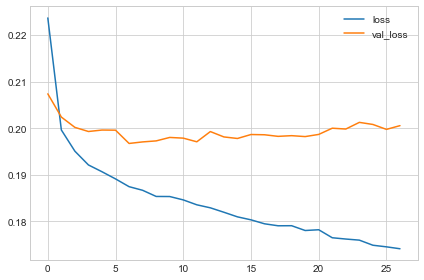

In [36]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));